# Code for all Figures

## Preliminaries

This notebook was running using Python 3.10.5 with the following packages:

* Numpy 1.23.1
* Pandas 1.4.3 
* Matplotlib 3.5.2
* Scipy 1.8.1
* Seaborn 0.11.2
* Jupyter Notebook 1.0.0 
* Csaps 1.1.0 ([see documentation](https://csaps.readthedocs.io/en/latest/))


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("paper",font_scale=2)

figsize_small = (7,5)

Hour = ['{:.0f}:00'.format(h) for h in [6,9,12,15,18]]
def create_plot(figsize):
    fig, axis = plt.subplots(1, 1, figsize=figsize)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_xticks([6,9,12,15,18])
    axis.set_xticklabels(Hour)
    axis.set_xlabel('Time')
    return fig, axis

def import_data():
    data = pd.read_csv('data.csv') # Data can be sent in email
    return data['t [h]'].values, data['w [g]'].values

## Data

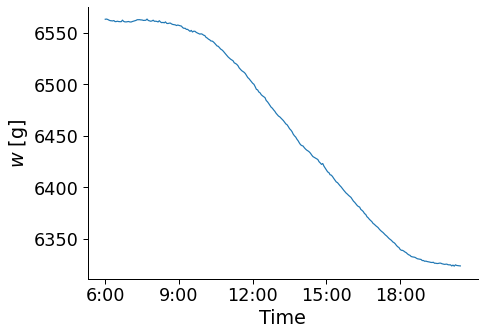

In [2]:
t, w = import_data()
N = len(t)

fig, axis = create_plot(figsize_small)
axis.set_ylabel('$w$ [g]')
axis.plot(t,w)
plt.savefig('WhiteThemeFigures/rawdata.pdf', bbox_inches='tight')

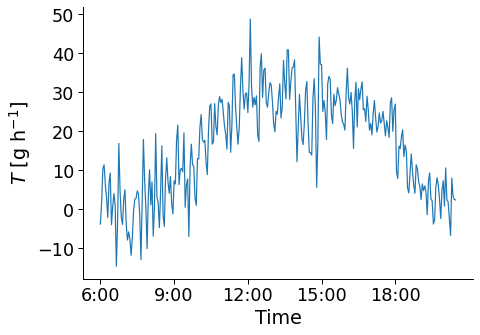

In [3]:
fig, axis = create_plot(figsize_small)
axis.set_ylabel('$T$ [g h$^{-1}$]')
axis.plot(t, - np.gradient(w, t))
plt.savefig('WhiteThemeFigures/noise.pdf', bbox_inches='tight')

## Moving Average

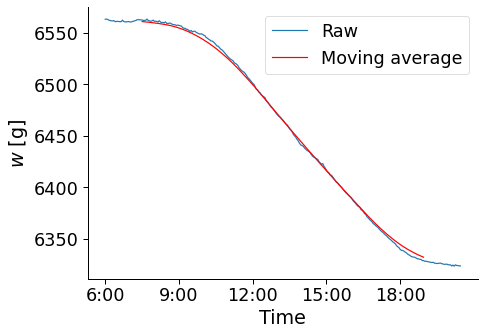

In [4]:
rolling_mean = pd.DataFrame(w, index=t).rolling(61, center=True).mean()
w_smooth = rolling_mean.values.flatten()
t_smooth = rolling_mean.index.values

mask = ~np.isnan(w_smooth)
w_smooth = w_smooth[mask]
t_smooth = t_smooth[mask]

fig, axis = create_plot(figsize_small)
axis.set_ylabel('$w$ [g]')
axis.plot(t,w, label='Raw')
axis.plot(t_smooth, w_smooth, c='red', label='Moving average')
axis.legend()
plt.savefig('WhiteThemeFigures/moving_average.pdf', bbox_inches='tight')

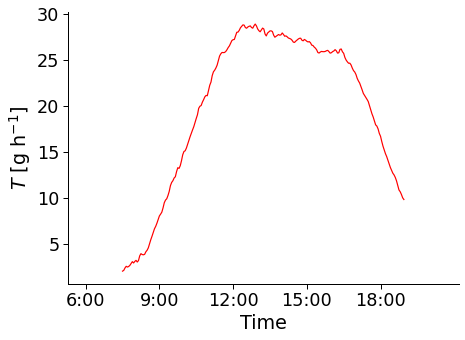

In [5]:
xlim = axis.get_xlim()
fig, axis = create_plot(figsize_small)
axis.set_ylabel('$T$ [g h$^{-1}$]')
axis.plot(t_smooth, - np.gradient(w_smooth, t_smooth), c='red')
axis.set_xlim(xlim)
plt.savefig('WhiteThemeFigures/moving_average_deriv.pdf', bbox_inches='tight')

## Spline

In [6]:
np.random.seed(42)

n = 500 # number of points
m = 5 # Number of knots
f = lambda t: 1.5 * np.sin(t)

t = np.sort(np.random.normal(3,1.2,size=n)) # x data - randomly numbers in [0,10]
t = t[(t > 0) & (t < 6)]
n = len(t)
w = f(t) + np.random.normal(0,0.4,size=n)
x = np.linspace(1,5,m)

# Plotting function for random data
def plot_random_data(x, knots_plot=True):
    _, axis = plt.subplots(1, 1, figsize=figsize_small)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_xticks([-10])
    axis.set_xticklabels([''])
    axis.set_yticks([-10])
    axis.set_yticklabels([''])
    if knots_plot:
        plt.vlines(x, -2.5, max(w)*1.1, colors='k', ls='--', alpha=0.7)
        if len(x)<=20:
            for i, x_i in enumerate(x):
                plt.text(x_i, -3, 'x$_{' + str(i)+'}$', fontsize=20, ha='center')
    plt.ylim(-3.2, max(w)*1.1,)
    plt.grid(b=False)

    plt.scatter(t, w, alpha=0.2)

    plt.ylabel('w')
    plt.xlabel('t')

We create the ordinary spline class for demonstration:

In [7]:
# Ordinary spline regressor class
class Spline():
    def __init__(self, k, x):
        self.k = k # poly order
        self.x = x # all of the knots
        self.m = len(x) # knots number
    
    # get basis function value
    def get_b(self, t_j, i):
        if i <= self.k:
            return t_j ** (i)
        j = i - (self.k + 1)
        return max(0, t_j - self.x[j]) ** self.k
    
    # get the basis functions values for all data in a matrix
    def get_B(self, t):
        n = len(t)
        B = np.zeros(shape=(n, self.m + self.k + 1))
        for j in range(n): # for each row
            for i in range(self.m + self.k + 1): # for each col
                B[j,i] = self.get_b(t[j], i)
        return B
    
    # fitting with normal equation
    def fit(self, t, w):
        B = self.get_B(t)
        self.beta_hat = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(w)

    # predicting
    def predict(self, t):
        B = self.get_B(t)
        return B.dot(self.beta_hat)


Use ordinary spline with different polynomial orders:

/var/folders/sn/hnkjpmxs545fmsm_vlk2sljw0000gn/T/ipykernel_12892/2235669189.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


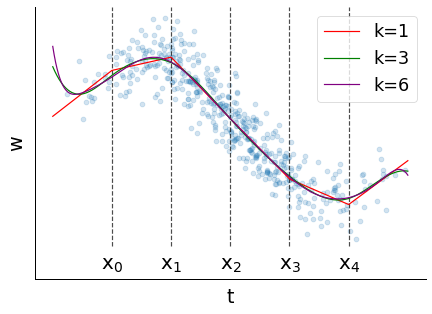

In [8]:
plot_random_data(x)
k_values = [1, 3, 6]
colors = ['red', 'green', 'purple']
t_pred = np.linspace(0,6,500)

for k, color in zip(k_values, colors):
    s = Spline(k, x)
    s.fit(t, w)
    w_pred = s.predict(t_pred)
    plt.plot(t_pred, w_pred, label='k='+str(k), c=color)

plt.legend()
plt.savefig('WhiteThemeFigures/spline1.pdf', bbox_inches='tight')

Use ordinary spline with different knots sets:

/var/folders/sn/hnkjpmxs545fmsm_vlk2sljw0000gn/T/ipykernel_12892/2235669189.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


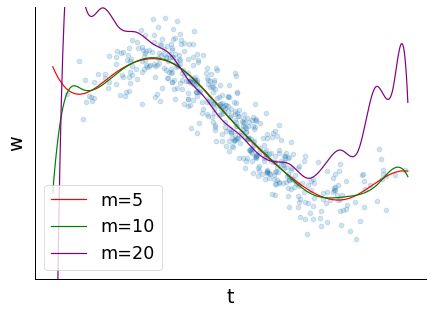

In [9]:
plot_random_data(x, False)
x_values = [np.linspace(1,5,5), np.linspace(0.5,5.5,10), np.linspace(0.25,5.75,20)]
k = 3

for x, color in zip(x_values, colors):
    m = len(x)
    s = Spline(k, x)
    s.fit(t, w)
    w_pred = s.predict(t_pred)
    plt.plot(t_pred, w_pred, label='m='+str(m), c=color)

plt.legend()
plt.savefig('WhiteThemeFigures/spline2.pdf', bbox_inches='tight')

We create the cubic natural spline class for demonstration:

In [10]:
class NaturalCubicSpline():
    def __init__(self, x):
        self.x = x
        self.m = len(x)

    # get d function value
    def get_d(self, t_j,j):
        nom = max(0, t_j - self.x[j]) ** 3 - max(0, t_j - self.x[self.m - 1]) ** 3
        denom = self.x[self.m - 1] - self.x[j]
        return nom / denom
    
    # get basis function value
    def get_b(self, t_j, i):
        if i < 2:
            return t_j ** (i)
        j = i - 2
        return self.get_d(t_j,j) - self.get_d(t_j,self.m - 2)

    # get the basis functions values for all data in a matrix
    def get_B(self, t):
        n = len(t)
        G = np.zeros(shape=(n, self.m - 1))
        for j in range(n): # for each row
            for i in range(self.m - 1): # for each col
                G[j,i] = self.get_b(t[j], i)
        return G

    def fit(self, t, y):
        B = self.get_B(t)
        self.beta_hat = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(y)
        
    def predict(self, t):
        B = self.get_B(t)
        return B.dot(self.beta_hat)

Showing the effect of the natural spline:

/var/folders/sn/hnkjpmxs545fmsm_vlk2sljw0000gn/T/ipykernel_12892/2235669189.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


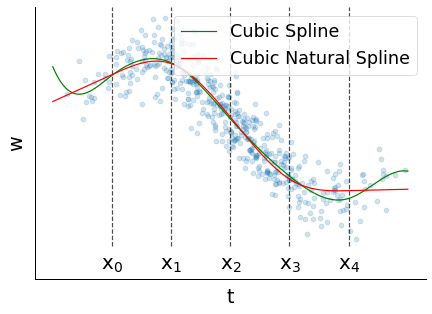

In [11]:
x = np.linspace(1,5,5)
plot_random_data(x)

s = Spline(3, x)
s.fit(t, w)
w_pred = s.predict(t_pred)
plt.plot(t_pred, w_pred, label='Cubic Spline', c='green')

s = NaturalCubicSpline(x)
s.fit(t, w)
w_pred = s.predict(t_pred)
plt.plot(t_pred, w_pred, label='Cubic Natural Spline', c='red')
plt.legend(loc='upper right')
plt.savefig('WhiteThemeFigures/cubicspline.pdf', bbox_inches='tight')

Using [Csap](https://csaps.readthedocs.io/en/latest/) package for the smoothing spline which is the Python implementation of the [Matlab Csap version](https://www.mathworks.com/help/curvefit/csaps.html). By default, $w_i$ and $\lambda$ are 1.

/var/folders/sn/hnkjpmxs545fmsm_vlk2sljw0000gn/T/ipykernel_12892/2235669189.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


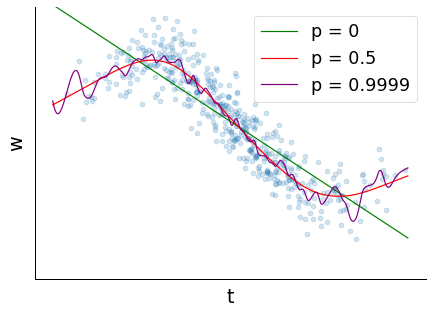

In [12]:
from csaps import CubicSmoothingSpline

plot_random_data(x, False)
colors = ['green', 'red', 'purple']

for p,c in zip([0, 0.5, 1-1e-4],colors):
    s = CubicSmoothingSpline(t, w, smooth=p).spline
    w_pred = s(t_pred)
    plt.plot(t_pred, w_pred, c=c, label=f'p = {p}')
plt.legend()
plt.savefig('WhiteThemeFigures/smoothspline.pdf', bbox_inches='tight')

Using it  on the real data:

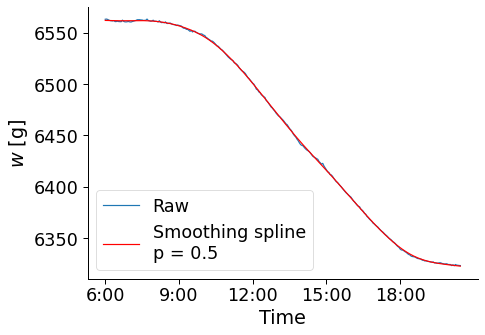

In [13]:
t, w = import_data()

fig, axis = create_plot(figsize_small)
axis.set_ylabel('$w$ [g]')
axis.plot(t,w, label='Raw')

p = 0.5
s = CubicSmoothingSpline(t, w, smooth=p).spline
w_pred = s(t)
axis.plot(t, w_pred, c='red', label=f'Smoothing spline\np = {p}')
axis.legend()
plt.savefig('WhiteThemeFigures/splinedata.pdf', bbox_inches='tight')

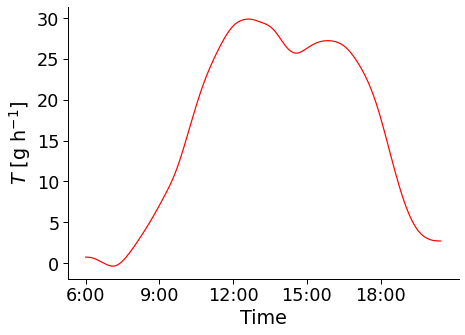

In [14]:
fig, axis = create_plot(figsize_small)
axis.set_ylabel('$T$ [g h$^{-1}$]')
axis.plot(t, - s.derivative()(t), c='red')
axis.set_xlim(xlim)
plt.savefig('WhiteThemeFigures/splinetranspiration.pdf', bbox_inches='tight')

## Savgol Filter

Explaining the method:

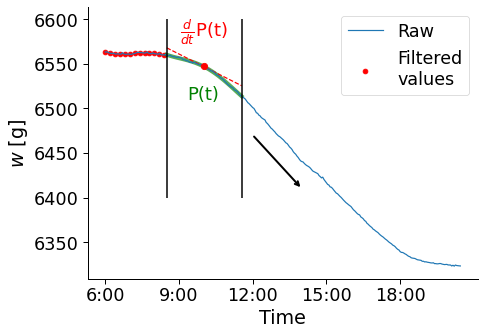

In [15]:
from scipy.signal import savgol_filter

fig, axis = create_plot(figsize_small)
axis.set_ylabel('$w$ [g]')
axis.plot(t,w, label='Raw')

window_size = 61
poly_order = 4

w_pred = savgol_filter(w, window_size, poly_order, 0)
dwdt_pred = savgol_filter(w, window_size, poly_order, 1, delta=t[1]-t[0])

# The window location with respect to the data indices
i_start_window = 50
i_center = i_start_window + window_size // 2
i_end_window = i_start_window + window_size

# "previously" filtered values
axis.scatter(t[:i_start_window:4], w_pred[:i_start_window:4], c='red', label=f'Filtered\nvalues')

# ploting windoe
axis.vlines([t[i_start_window], t[i_end_window]], 6400, 6600, colors='k', lw=1.5)

# plotting the polynomial
coef = np.polyfit(t[i_start_window:i_end_window], w[i_start_window:i_end_window], deg=poly_order)
poly = np.poly1d(coef)
seq = np.linspace(t[i_start_window], t[i_end_window], 100)
axis.plot(seq, poly(seq), c='green', lw=4, alpha=0.65, zorder=1)
axis.scatter(t[i_center], w_pred[i_center], c='red',s=40, zorder=3)

# plotting the tangent
tan_m = dwdt_pred[i_center]
tan_c = w_pred[i_center] - tan_m * t[i_center]
axis.plot(seq, tan_m * seq + tan_c, c='red', ls='--', zorder=1)

# other annotations
axis.text(t[i_center], 6510, 'P(t)', c='green', ha='center', fontsize=18)
axis.text(t[i_center], 6580, r'$\frac{d}{dt}$P(t)', c='red', ha='center', fontsize=18)
axis.annotate(text='', xy=(12,6470), xytext=(14,6410), arrowprops=dict(arrowstyle='<-', linewidth=2))

axis.legend()
plt.savefig('WhiteThemeFigures/savgol1.pdf', bbox_inches='tight')

Using it on the data:

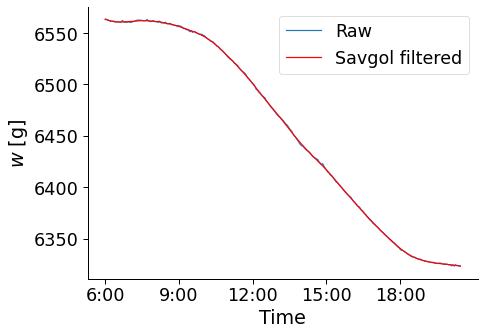

In [16]:
fig, axis = create_plot(figsize_small)
axis.set_ylabel('$w$ [g]')
axis.plot(t,w, label='Raw')

window_size = 61
poly_order = 4

w_pred = savgol_filter(w, window_size, poly_order, 0)

axis.plot(t, w_pred, c='red', label='Savgol filtered')
axis.legend()
plt.savefig('WhiteThemeFigures/savgol2.pdf', bbox_inches='tight')

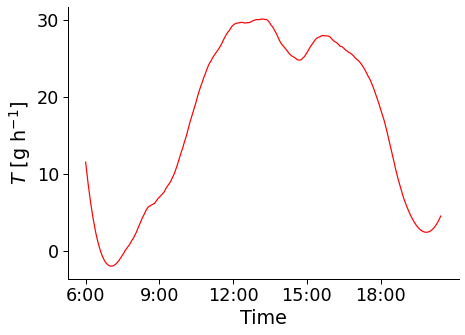

In [17]:
fig, axis = create_plot(figsize_small)
axis.set_ylabel('$T$ [g h$^{-1}$]')
axis.plot(t, - savgol_filter(w, window_size, poly_order, deriv=1, delta=t[1] - t[0]), c='red')
plt.savefig('WhiteThemeFigures/savgol3.pdf', bbox_inches='tight')

## Discrete Forier Transform

The function gets the data values with filtered weight and preformed the analysis described in 2.4.1 section

In [18]:
def FFT_analysis(y_smooth, y, threshod, name=None, t_smooth=[], mask=[], dydt_smoothed=[], legend=False):

    # plotting weight and smoothed weight
    if len(t_smooth) == 0: # in case the smoothing keep the same shape of the orginal data
        t_smooth = t
    fig, axis1 = create_plot(figsize_small)
    axis1.set_ylabel('$w$ [g]')
    axis1.plot(t,y, label='Raw')
    axis1.plot(t_smooth, y_smooth, c='red', label='Smoothed')
    if name != None:
        plt.savefig('WhiteThemeFigures/Spectral/' + name + '1.pdf', bbox_inches='tight')   
    
    # masking y according to where there is no nan values in the dydt
    if len(mask) != 0:
        y = y[mask]
    
    # Transforming residual with DFT (using the FFT algorithm)
    error = y - y_smooth
    N = len(error)
    dt = 0.05
    H = np.fft.fft(error)
    H_mag = np.sqrt(H * np.conj(H))
    
    # The functions returns all possible freq up to half of the measurement freq including negative
    # Negative are appended just after positive (i.e., freq[:N//2] -> only positive; freq[N//2:] -> only negative)
    freq = np.fft.fftfreq(N, dt) 

    # plot Fourier transformed result of the weight error
    fig, axis3 = plt.subplots(1, 1, figsize=figsize_small)
    axis3.spines['right'].set_visible(False)
    axis3.spines['top'].set_visible(False)
    plt.plot(freq[:N//2], H_mag[:N//2], marker='.')
    plt.xlabel('f [h$^{-1}$]')
    plt.ylabel('Residual $|H|$')
    if name != None:
        plt.savefig('WhiteThemeFigures/Spectral/' + name + '3.pdf', bbox_inches='tight')

    # Calculating the low pass residual
    H_low_pass = H * (np.abs(freq) < threshod) # including negative freq
    error_low_pass = np.fft.ifft(H_low_pass) # Inverse Fourier Transform

    # plotting smoothed transpiration
    xlim = axis1.get_xlim()
    fig, axis2= create_plot(figsize_small)
    axis2.set_ylabel('$T$ [g h$^{-1}$]')
    if len(dydt_smoothed) != 0:
        axis2.plot(t_smooth, - dydt_smoothed, c='red', label='Smoothed')
    else: # in case we need to use central difference on the filtered data
        axis2.plot(t_smooth, - np.gradient(y_smooth, t_smooth), c='red', label='Smoothed')
    axis2.set_xlim(xlim)

    # Plotting the transpiration using central difference on the sum of the filtered y and the low pass residual
    axis2.plot(t_smooth, -np.gradient(y_smooth + error_low_pass, t_smooth), c='k', label='Smoothed + low pass\nresidual noise')
    if legend:
        axis2.legend()
    if name != None:
        plt.savefig('WhiteThemeFigures/Spectral/' + name + '2.pdf', bbox_inches='tight')
    return t_smooth, -np.gradient(y_smooth + error_low_pass, t_smooth)

/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


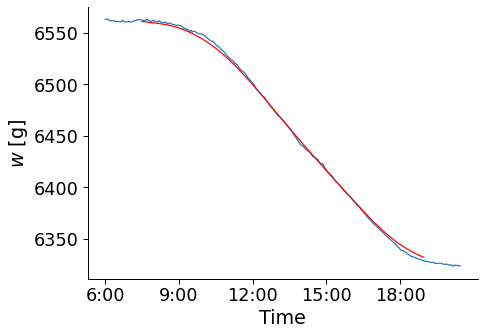

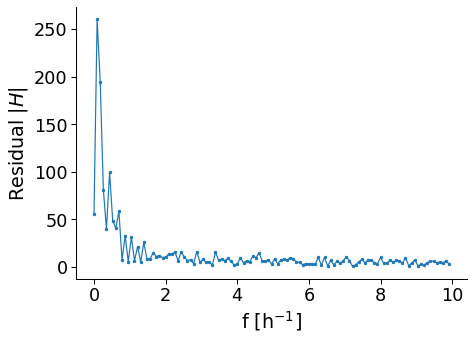

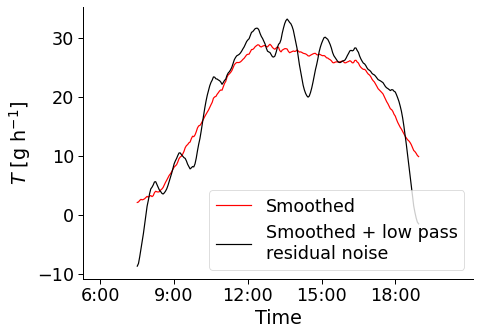

In [19]:
rolling_mean = pd.DataFrame(w, index=t).rolling(61, center=True).mean()
w_moving_avg = rolling_mean.values.flatten()
t_moving_avg = rolling_mean.index.values

mask = ~np.isnan(w_moving_avg)
w_moving_avg = w_moving_avg[mask]
t_moving_avg = t_moving_avg[mask]

avg_t, avg_trans = FFT_analysis(w_moving_avg, w, 1, t_smooth=t_moving_avg, mask=mask, legend=True, name='FFT_avg')

/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


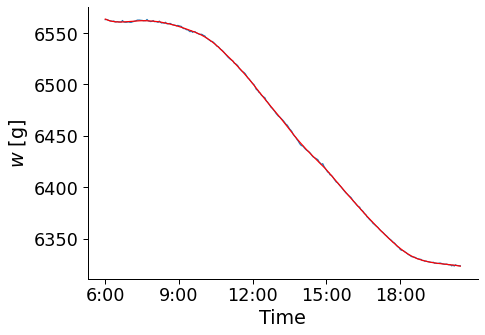

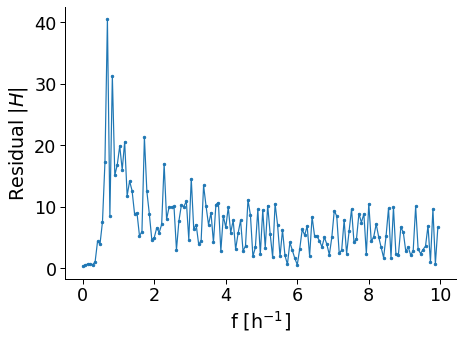

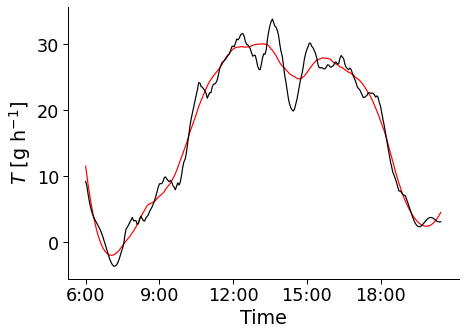

In [20]:
savgol_t, savgol_trans = FFT_analysis(savgol_filter(w, 61, 4, 0), w, 1, dydt_smoothed=savgol_filter(w, 61, 4, 1, delta=0.05), name='FFT_savgol')

/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


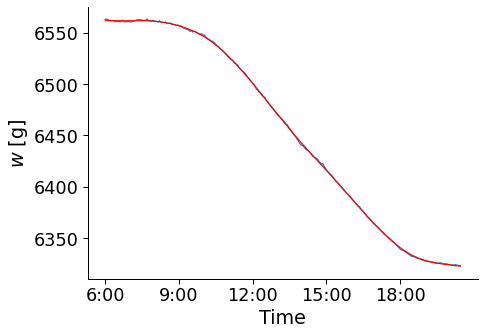

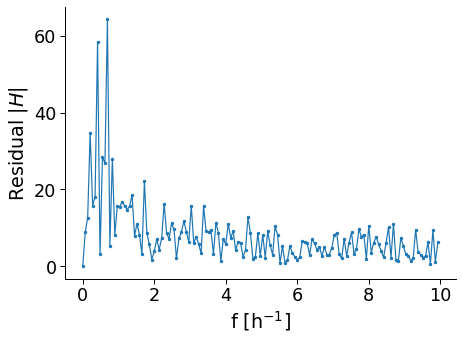

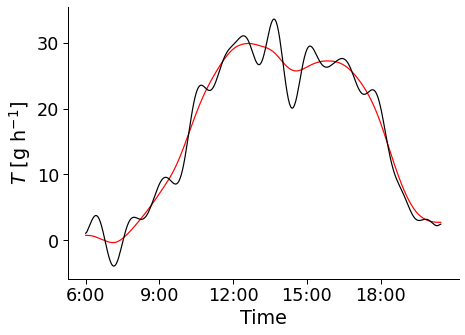

In [21]:
s = CubicSmoothingSpline(t, w, smooth=0.5).spline
spline_t, spline_trans = FFT_analysis(s(t), w, 1, dydt_smoothed=s.derivative()(t), name='FFT_spline')

The next function is used for section 2.4.2. We pass in the filtered transpiration with low smoothness degree. The function plot it and its spectral analysis graph

/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


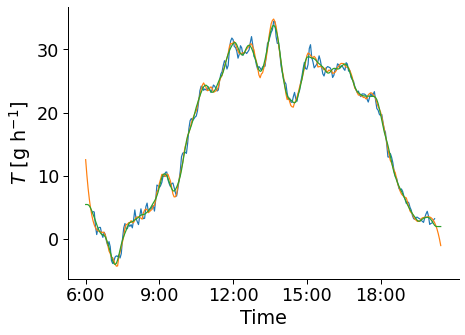

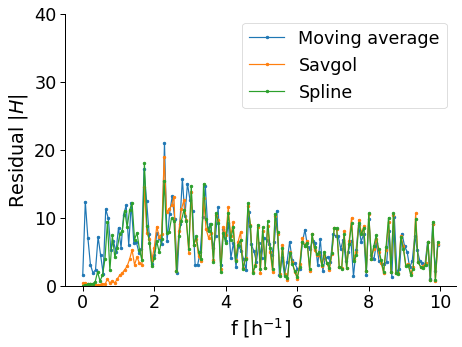

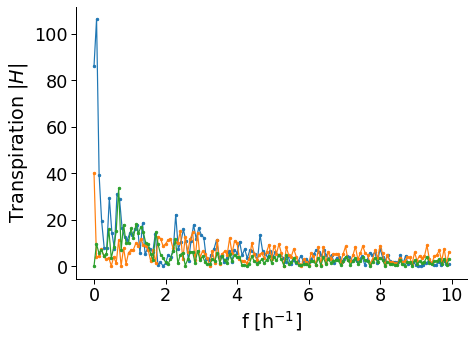

In [22]:
def comparison(axes, dydt, t_smoothed, residual, label):

    axes[0].plot(t_smoothed, -dydt)
    axes[0].set_xticks([6,9,12,15,18])
    axes[0].set_xticklabels(Hour)
    axes[0].set_xlabel('Time')

    N = len(residual)
    dt = 0.05

    freq = np.fft.fftfreq(N, dt) 

    H_residual = np.fft.fft(residual)
    H_mag_residual = np.sqrt(H_residual * np.conj(H_residual))
    axes[1].plot(freq[:N //2], H_mag_residual[:N // 2], marker='.', label=label)

    H_trans = np.fft.fft(dydt)
    H_mag_trans = np.sqrt(H_trans * np.conj(H_residual))
    axes[2].plot(freq[:N //2], H_mag_trans[:N // 2], marker='.', label=label)

# Setting all figures
fig1, axis1 = plt.subplots(1, 1, figsize=figsize_small)
fig2, axis2 = plt.subplots(1, 1, figsize=figsize_small)
fig3, axis3 = plt.subplots(1, 1, figsize=figsize_small)
axis1.set_ylabel('$T$ [g h$^{-1}$]')
axis1.set_xlabel('Time')
axis2.set_xlabel('f [h$^{-1}$]')
axis2.set_ylabel('Residual $|H|$')
axis3.set_xlabel('f [h$^{-1}$]')
axis3.set_ylabel('Transpiration $|H|$')

axes = [axis1, axis2, axis3]
for axis in axes:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)


# Moving average
rolling_mean = pd.DataFrame(w, index=t).rolling(11, center=True).mean()
y_moving_avg = rolling_mean.values.flatten()
t_moving_avg = rolling_mean.index.values

mask = ~np.isnan(y_moving_avg)
y_moving_avg = y_moving_avg[mask]
t_moving_avg = t_moving_avg[mask]

comparison(axes, np.gradient(y_moving_avg, t_moving_avg), t_moving_avg, w[mask] - y_moving_avg, 'Moving average')

# Savgol
window = 25
poly = 4
y_smoothed = savgol_filter(w, window, poly, 0)
dydt_smoothed = savgol_filter(w, window, poly, 1, 0.05)
comparison(axes, dydt_smoothed, t, w - y_smoothed, 'Savgol')


# Smoothing Spline
p = 0.99
s = CubicSmoothingSpline(t, w, smooth=p).spline
y_smoothed = s(t)
dydt_smoothed = s.derivative()(t)
comparison(axes, dydt_smoothed, t, w - y_smoothed, 'Spline')
axis2.legend()
axis2.set_ylim(0,40)

fig1.savefig('WhiteThemeFigures/Comparison1.pdf')
fig2.savefig('WhiteThemeFigures/Comparison2.pdf')